In [176]:
import pandas as pd
import numpy as np
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc, concordance_index_censored, integrated_brier_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

import random

import optuna
from sksurv.nonparametric import kaplan_meier_estimator

<p>All 5 of the imputed datasets</p>

In [66]:
train1 = pd.read_csv("../data/imputations/final_w_imps_1.csv")
train2 = pd.read_csv("../data/imputations/final_w_imps_2.csv")
train3 = pd.read_csv("../data/imputations/final_w_imps_3.csv")
train4 = pd.read_csv("../data/imputations/final_w_imps_4.csv")
train5 = pd.read_csv("../data/imputations/final_w_imps_5.csv")

train = [train1, train2, train3, train4, train5]

test1 = pd.read_csv("../data/imputations/final_w_imps_1_test.csv")
test2 = pd.read_csv("../data/imputations/final_w_imps_2_test.csv")
test3 = pd.read_csv("../data/imputations/final_w_imps_3_test.csv")
test4 = pd.read_csv("../data/imputations/final_w_imps_4_test.csv")
test5 = pd.read_csv("../data/imputations/final_w_imps_5_test.csv")

test = [test1, test2, test3, test4, test5]

<p>Removing the Pseudo-observation columns</p>

In [67]:
for idx in range(len(train)):
    train[idx] = train[idx].loc[:, ~train[idx].columns.str.startswith("PO_")]

for idx in range(len(test)):
    test[idx] = test[idx].loc[:, ~test[idx].columns.str.startswith("PO_")]

<p>Grouping ethnicities</p>

In [68]:
def collapse_ethnicity(val):
    val = str(val).upper()
    if "ASIAN" in val:
        return "Asian"
    elif "WHITE" in val or "MIDDLE" in val:
        return "White"
    elif "BLACK" in val:
        return "Black or African American"
    elif any(word in val for word in ["OTHER", "PATIENT", "UNABLE", "UNKNOWN"]):
        return "Unknown"
    elif "AMERICAN" in val:
        return "American Indian or Alaska Native"
    elif "HISPANIC" in val:
        return "Hispanic"
    elif "MULTI" in val:
        return "More than one race"
    else:
        return val

# Apply ethnicity collapsing to each dataframe in ds
for i in range(len(train)):
    if 'ethnicity' in train[i].columns:
        train[i]['ethnicity'] = train[i]['ethnicity'].apply(collapse_ethnicity)

for i in range(len(test)):
    if 'ethnicity' in test[i].columns:
        test[i]['ethnicity'] = test[i]['ethnicity'].apply(collapse_ethnicity)

C:\Users\qrJos\AppData\Local\Temp\ipykernel_2248\3172019743.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]['ethnicity'] = train[i]['ethnicity'].apply(collapse_ethnicity)
C:\Users\qrJos\AppData\Local\Temp\ipykernel_2248\3172019743.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]['ethnicity'] = test[i]['ethnicity'].apply(collapse_ethnicity)


<p>Splitting into X and y for each dataset</p>
<p>Combines into one dataset for onehot encoding before resplitting</p>

In [124]:
def splitXY(train_dfs, test_dfs):
    # Track lengths for re-splitting
    train_lengths = [len(df) for df in train_dfs]
    test_lengths = [len(df) for df in test_dfs]

    # Combine all into one DataFrame (with origin label)
    combined = pd.concat(train_dfs + test_dfs, ignore_index=True)

    # Clip negative times
    combined["survival_days"] = combined["survival_days"].clip(lower=0)
    combined["surv_days_w_mean_imps"] = combined["surv_days_w_mean_imps"].clip(lower=0)

    # Create binary outcome
    combined["survived_90"] = combined["survival_days"] > 90

    # Do one-hot encoding across the entire dataset
    X_all = pd.get_dummies(combined.drop(columns=["subject_id", "survival_days", "survived_90", "event", "surv_days_w_mean_imps", "delta"]))
    y_all = combined["surv_days_w_mean_imps"]
    y_event = combined["event"]

    # Rebuild structured target
    y_struct_all = Surv.from_arrays(event=y_event.astype(bool), time=y_all)

    # Re-split into original pieces
    X_train, y_train, X_test, y_test = [], [], [], []

    train_cumsum = [0] + list(pd.Series(train_lengths).cumsum())
    test_cumsum = [train_cumsum[-1]] + list((pd.Series(test_lengths).cumsum() + train_cumsum[-1]))

    # Slice train
    for i in range(len(train_dfs)):
        X_train.append(X_all.iloc[train_cumsum[i]:train_cumsum[i+1]].reset_index(drop=True))
        y_train.append(y_struct_all[train_cumsum[i]:train_cumsum[i+1]])

    # Slice test
    for i in range(len(test_dfs)):
        X_test.append(X_all.iloc[test_cumsum[i]:test_cumsum[i+1]].reset_index(drop=True))
        y_test.append(y_struct_all[test_cumsum[i]:test_cumsum[i+1]])

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = splitXY(train, test)

In [226]:
def run_rsf(X_train_set, y_train_set, X_test_set, y_test_set, plot_fp=False):
    
    # BASE MODEL
    # rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, random_state=7)

    # OPTIMIZED, MODEL, BEST C-Index of 0.833079
    rsf = RandomSurvivalForest(n_estimators=266, min_samples_split=11, min_samples_leaf=11, max_features="log2")
    
    # OPTIMIZED MODEL, Best IBS of 0.074776
    #rsf = RandomSurvivalForest(n_estimators=243, min_samples_split=3, min_samples_leaf=1, max_features="sqrt")

    # Fit the model
    rsf.fit(X_train_set, y_train_set)

    # Predict survival functions
    surv_funcs = rsf.predict_survival_function(X_test_set)

    # Define evaluation time points
    time_buckets = np.array([7, 30, 60, 180, 365, 730])
    surv_probs = np.row_stack([fn(time_buckets) for fn in surv_funcs])
    risk_scores = 1 - surv_probs  # Higher risk = lower survival

    c_rsf = []
    
    print("  RSF C-index per time bucket:")
    for i, t in enumerate(time_buckets):
        c_index, _, _, _, _ = concordance_index_censored(
            y_test_set["event"], [x[1] for x in y_test_set], risk_scores[:, i]
        )
        print(f"    Day {t:4d}: C-index = {c_index:.4f}")
        c_rsf.append(c_index)
    print(f"  Mean RSF C-index: {sum(c_rsf) / len(c_rsf):4f}")

    # Full IBS over a grid
    surv_probs_grid = np.row_stack([fn(time_buckets) for fn in surv_funcs])
    ibs = integrated_brier_score(y_train_set, y_test_set, surv_probs_grid, time_buckets)
    print(f"  RSF IBS:     {ibs:.4f}")

    # Permutation importance
    if plot_fp:
        perm_result = permutation_importance(
            rsf, X_test_set, y_test_set, n_repeats=10, random_state=42, n_jobs=-1
        )
        sorted_idx = perm_result.importances_mean.argsort()[::-1][:20]

        plt.figure(figsize=(10, 6))
        plt.barh(range(len(sorted_idx)), perm_result.importances_mean[sorted_idx][::-1], align='center')
        plt.yticks(range(len(sorted_idx)), X_test_set.columns[sorted_idx][::-1])
        plt.xlabel("Permutation Importance (Mean decrease in score)")
        plt.title("RSF Permutation Feature Importance (Top 20)")
        plt.tight_layout()
        plt.show()

    return sum(c_rsf) / len(c_rsf), ibs

def run_gb(X_train_set, y_train_set, X_test_set, y_test_set, plot_fp=False):

    # OPTIMIZED MODEL, Best C-Index of 0.828619
    gb = GradientBoostingSurvivalAnalysis(n_estimators=283, learning_rate=0.233, max_depth=1, random_state=7)

    # OPTIMIZED MODEL, Best IBS Score of 0.0741945
    #gb = GradientBoostingSurvivalAnalysis(n_estimators=281, learning_rate=0.218, max_depth=1, random_state=7)

    # Train the model
    gb.fit(X_train_set, y_train_set)

    # Predict survival functions
    surv_funcs = gb.predict_survival_function(X_test_set)

    # Define time buckets
    time_buckets = np.array([7, 30, 60, 180, 365, 730])
    surv_probs = np.row_stack([fn(time_buckets) for fn in surv_funcs])
    risk_scores = 1 - surv_probs  # Higher risk = lower survival

    c_gb = []
    print("  GB Time-dependent C-index per time bucket:")
    for i, t in enumerate(time_buckets):
        c_index, _, _, _, _ = concordance_index_ipcw(
            y_train_set, y_test_set, estimate=risk_scores[:, i], tau=t
        )
        print(f"    Day {t:4d}: C-index = {c_index:.4f}")
        c_gb.append(c_index)
    print(f"  Mean GB C-index: {np.mean(c_gb):.6f}")

    
    # IBS
    surv_probs_grid = np.row_stack([fn(time_buckets) for fn in surv_funcs])
    ibs = integrated_brier_score(y_train_set, y_test_set, surv_probs_grid, time_buckets)
    print(f"  GB IBS:      {ibs:.4f}")

    # Feature importance
    if plot_fp:
        fi_gb = gb.feature_importances_
        top_idx = np.argsort(fi_gb)[::-1][:20]

        plt.figure(figsize=(10, 6))
        plt.barh(range(len(top_idx)), fi_gb[top_idx][::-1], align='center')
        plt.yticks(range(len(top_idx)), X_test_set.columns[top_idx][::-1])
        plt.xlabel("Feature Importance")
        plt.title("Gradient Boosting - Top 20 Feature Importances")
        plt.tight_layout()
        plt.show()

    return sum(c_gb) / len(c_gb), ibs



Train Set 0, Test Set 4:
  RSF C-index per time bucket:
    Day    7: C-index = 0.7802
    Day   30: C-index = 0.7658
    Day   60: C-index = 0.7885
    Day  180: C-index = 0.8276
    Day  365: C-index = 0.8298
    Day  730: C-index = 0.8344
  Mean RSF C-index: 0.804387
  RSF IBS:     0.0817


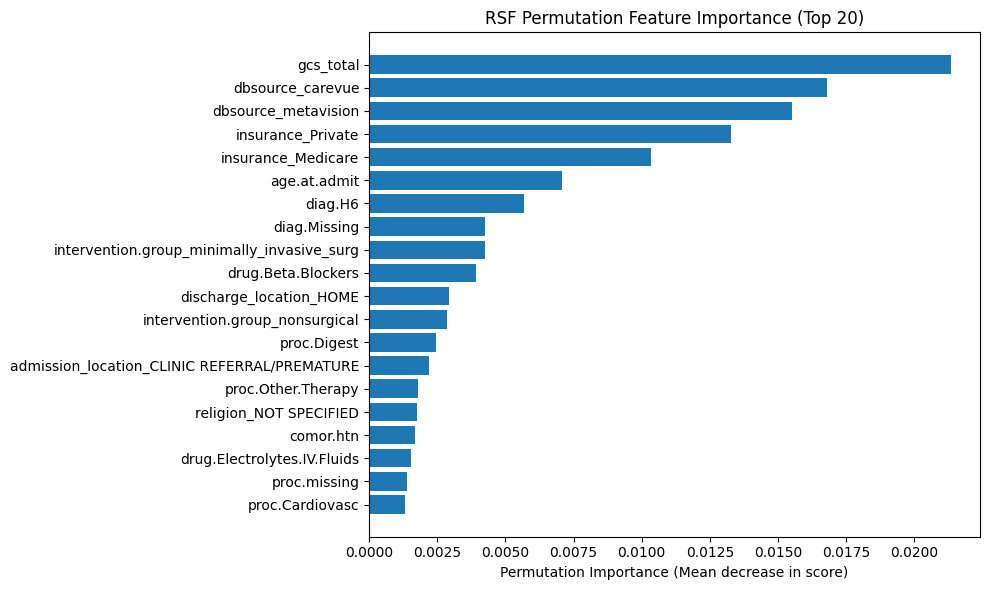


  GB Time-dependent C-index per time bucket:
    Day    7: C-index = 0.7787
    Day   30: C-index = 0.7732
    Day   60: C-index = 0.8065
    Day  180: C-index = 0.8204
    Day  365: C-index = 0.8281
    Day  730: C-index = 0.8364
  Mean GB C-index: 0.807234
  GB IBS:      0.0712


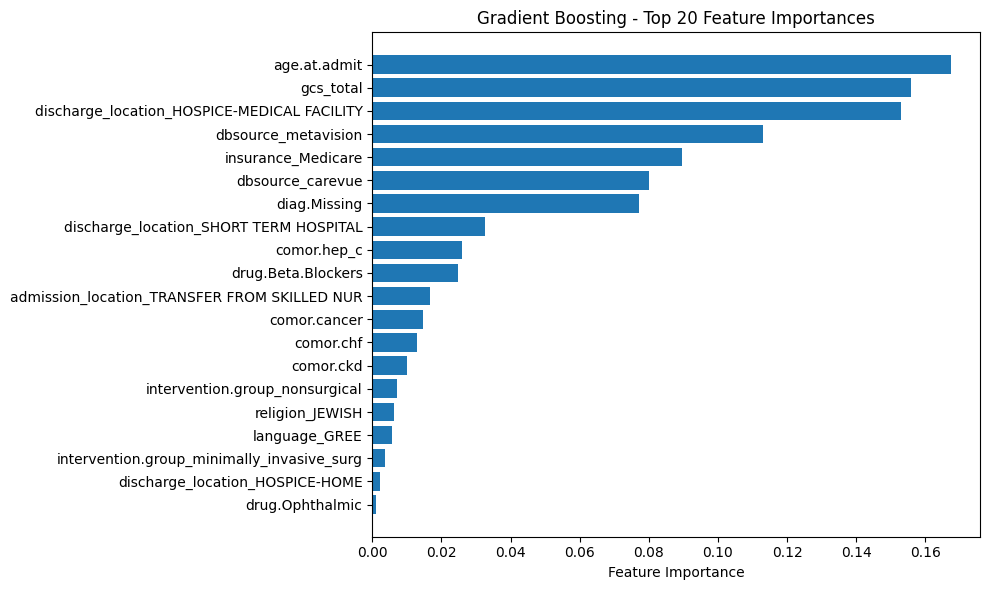



Train Set 1, Test Set 0:
  RSF C-index per time bucket:
    Day    7: C-index = 0.7709
    Day   30: C-index = 0.7643
    Day   60: C-index = 0.7891
    Day  180: C-index = 0.8165
    Day  365: C-index = 0.8154
    Day  730: C-index = 0.8206
  Mean RSF C-index: 0.796137
  RSF IBS:     0.0823


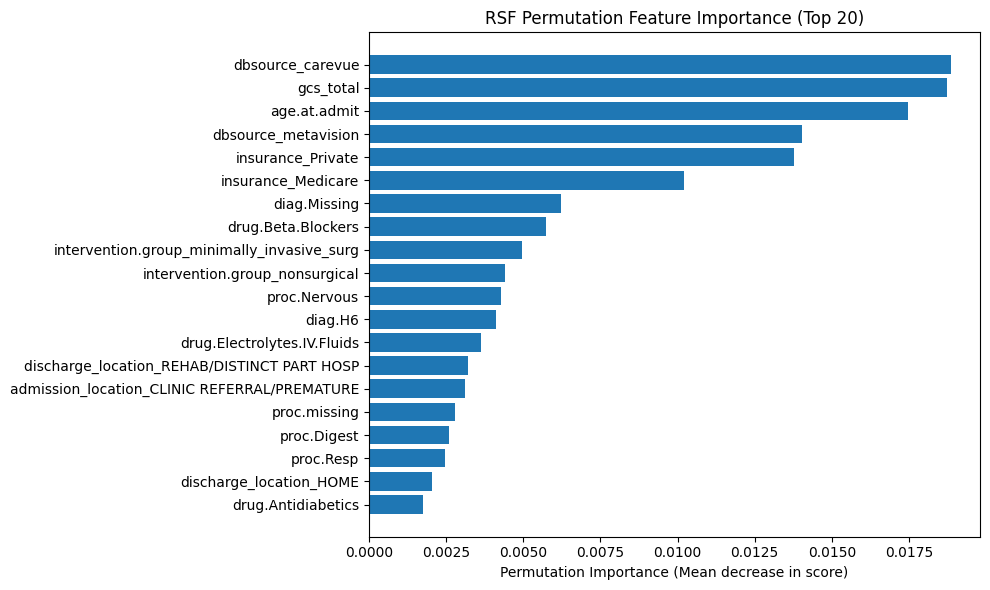


  GB Time-dependent C-index per time bucket:
    Day    7: C-index = 0.7288
    Day   30: C-index = 0.7553
    Day   60: C-index = 0.7872
    Day  180: C-index = 0.8061
    Day  365: C-index = 0.8120
    Day  730: C-index = 0.8207
  Mean GB C-index: 0.785013
  GB IBS:      0.0760


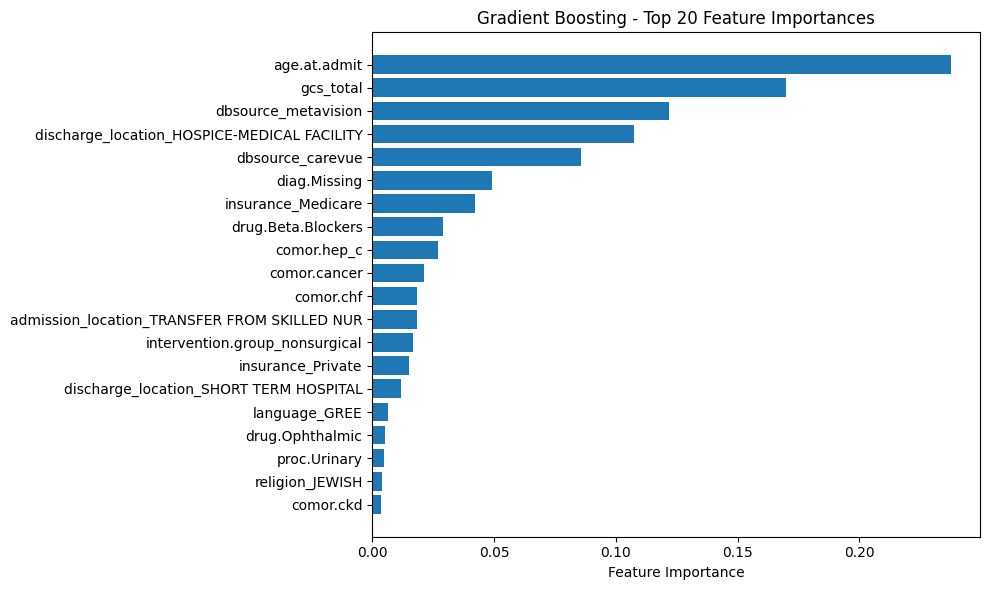



Train Set 2, Test Set 3:
  RSF C-index per time bucket:
    Day    7: C-index = 0.7961
    Day   30: C-index = 0.7794
    Day   60: C-index = 0.8044
    Day  180: C-index = 0.8372
    Day  365: C-index = 0.8360
    Day  730: C-index = 0.8392
  Mean RSF C-index: 0.815395
  RSF IBS:     0.0812


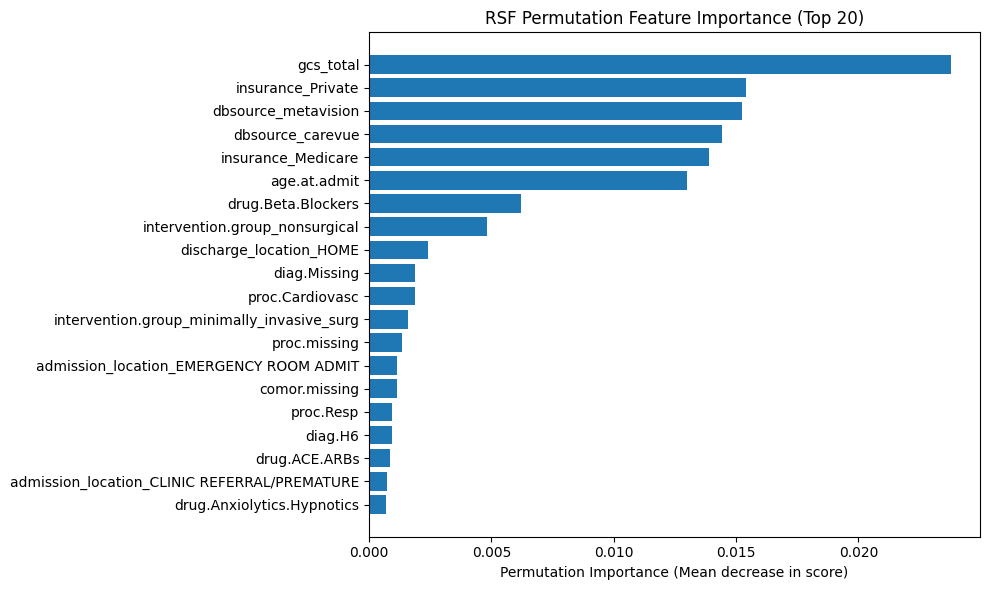


  GB Time-dependent C-index per time bucket:
    Day    7: C-index = 0.7696
    Day   30: C-index = 0.7795
    Day   60: C-index = 0.8101
    Day  180: C-index = 0.8212
    Day  365: C-index = 0.8269
    Day  730: C-index = 0.8371
  Mean GB C-index: 0.807397
  GB IBS:      0.0736


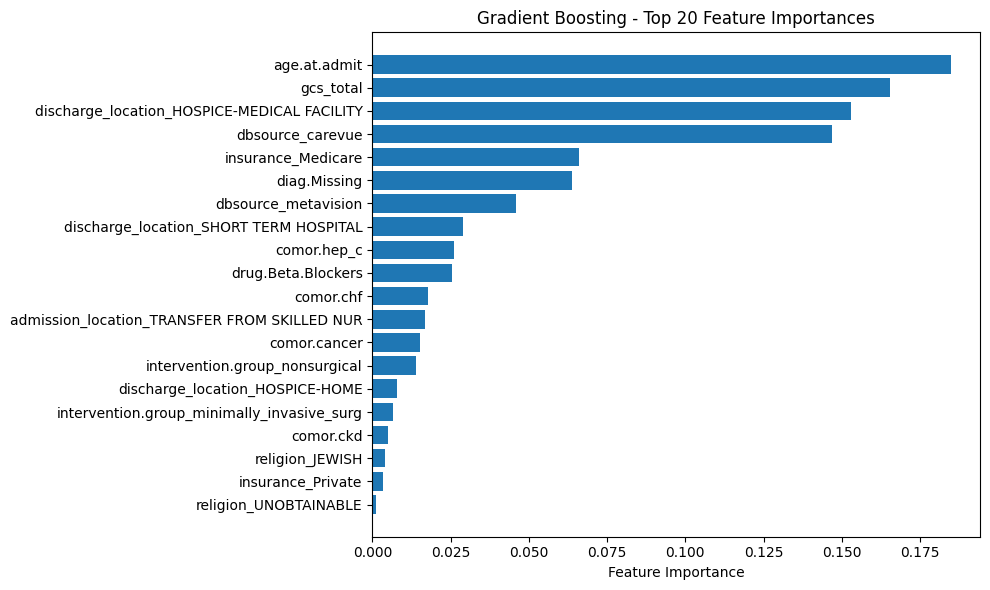



Train Set 3, Test Set 1:
  RSF C-index per time bucket:
    Day    7: C-index = 0.7708
    Day   30: C-index = 0.7612
    Day   60: C-index = 0.7799
    Day  180: C-index = 0.8147
    Day  365: C-index = 0.8165
    Day  730: C-index = 0.8222
  Mean RSF C-index: 0.794238
  RSF IBS:     0.0825


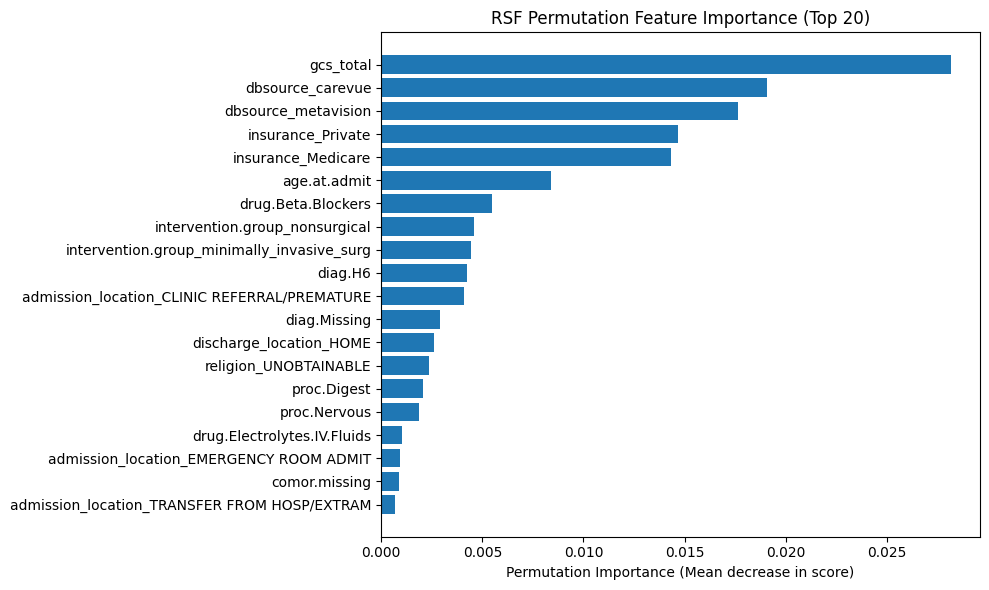


  GB Time-dependent C-index per time bucket:
    Day    7: C-index = 0.7662
    Day   30: C-index = 0.7715
    Day   60: C-index = 0.7970
    Day  180: C-index = 0.8090
    Day  365: C-index = 0.8102
    Day  730: C-index = 0.8168
  Mean GB C-index: 0.795110
  GB IBS:      0.0810


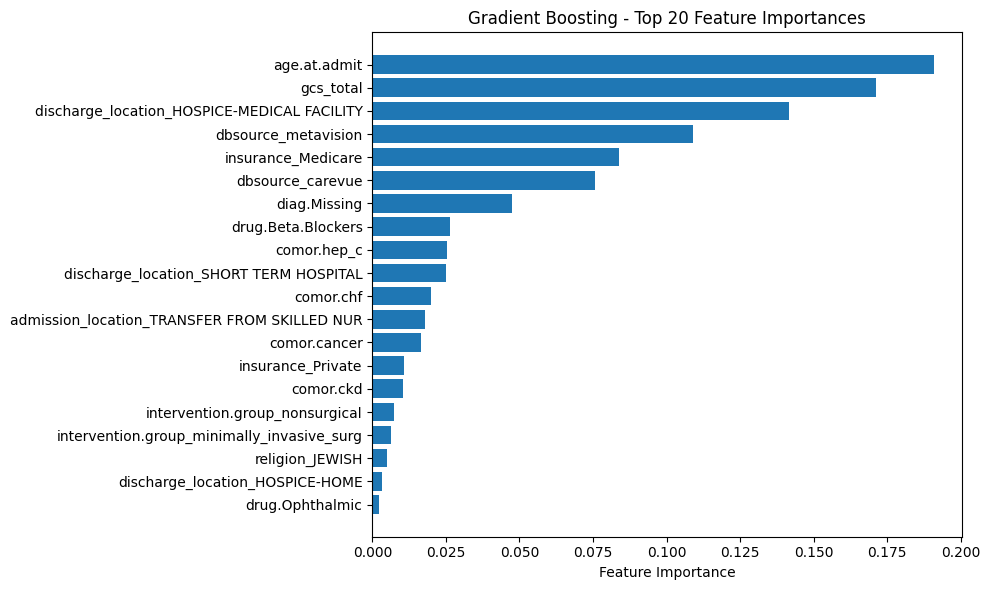



Train Set 4, Test Set 2:
  RSF C-index per time bucket:
    Day    7: C-index = 0.7777
    Day   30: C-index = 0.7621
    Day   60: C-index = 0.7861
    Day  180: C-index = 0.8271
    Day  365: C-index = 0.8284
    Day  730: C-index = 0.8342
  Mean RSF C-index: 0.802605
  RSF IBS:     0.0816


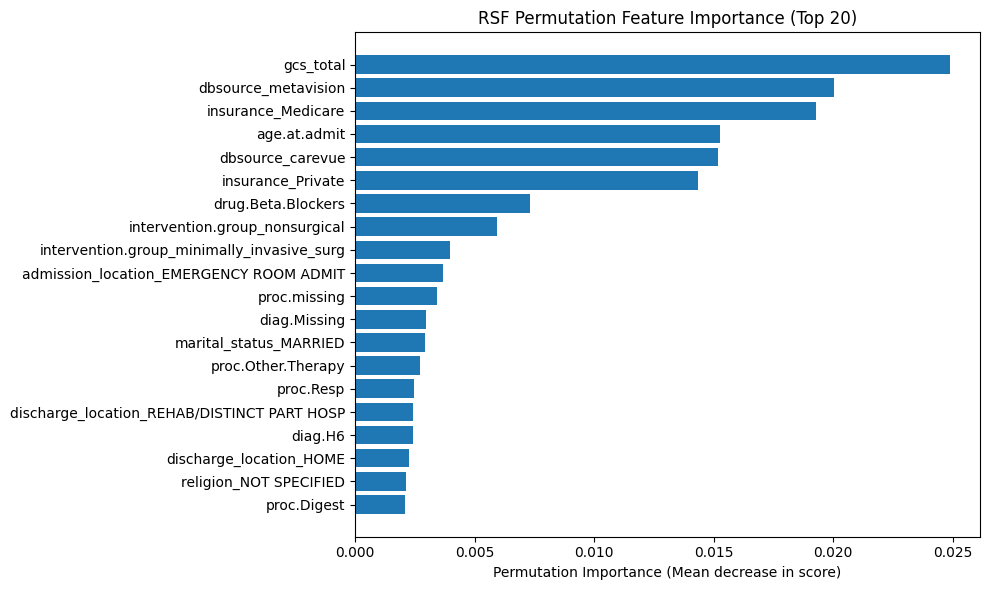


  GB Time-dependent C-index per time bucket:
    Day    7: C-index = 0.7779
    Day   30: C-index = 0.7767
    Day   60: C-index = 0.8057
    Day  180: C-index = 0.8198
    Day  365: C-index = 0.8263
    Day  730: C-index = 0.8331
  Mean GB C-index: 0.806607
  GB IBS:      0.0720


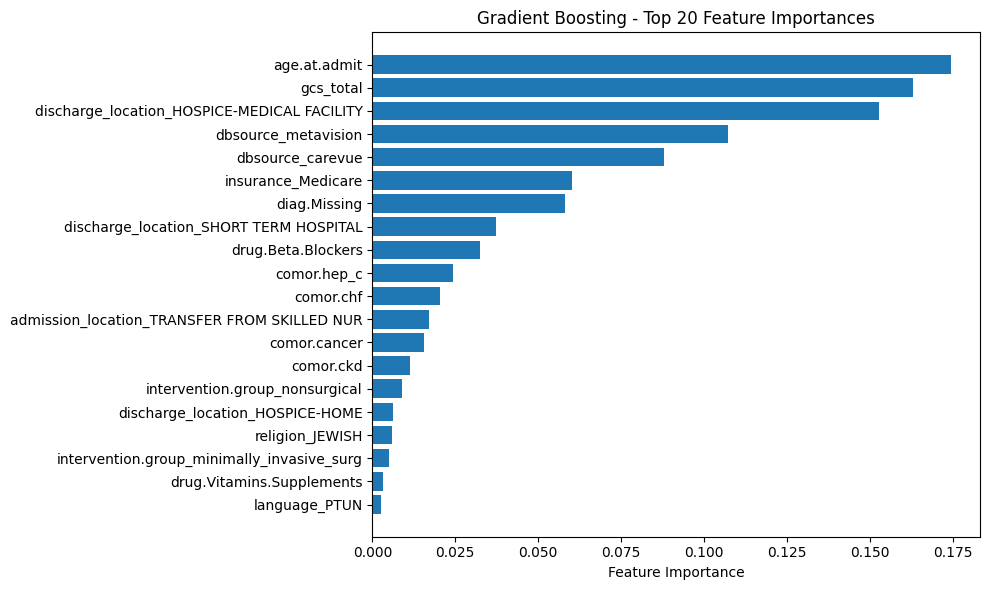



Average C-Index | IBS for the RSF Model: 0.8026 | 0.0818
Average C-Index | IBS for the GB Model: 0.8003 | 0.0748


In [227]:
indices = [0, 1, 2, 3, 4]
random.shuffle(indices)

c_rsf, c_gb, ibs_rsf, ibs_gb = [], [], [], []
for i, j in enumerate(indices):
    print(f"Train Set {i}, Test Set {j}:")
    c_rsf_ind, ibs_rsf_ind = run_rsf(X_train[i], y_train[i], X_test[j], y_test[j], plot_fp = True)
    c_rsf.append(c_rsf_ind)
    ibs_rsf.append(ibs_rsf_ind)
    print()
    c_gb_ind, ibs_gb_ind = run_gb(X_train[i], y_train[i], X_test[j], y_test[j], plot_fp = True)
    c_gb.append(c_gb_ind)
    ibs_gb.append(ibs_gb_ind)
    print()
    print()

print(f"Average C-Index | IBS for the RSF Model: {sum(c_rsf) / len(c_rsf):.4f} | {sum(ibs_rsf) / len(ibs_rsf):.4f}")
print(f"Average C-Index | IBS for the GB Model: {sum(c_gb) / len(c_gb):.4f} | {sum(ibs_gb) / len(ibs_gb):.4f}")

RSF C Index:
    7 Day: 

In [193]:
import optuna
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

def rsf_objective_cindex(trial):
    # Sample hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 15)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    rsf = RandomSurvivalForest(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=7,
    )
    
    c_rsf = []

    indices = [0, 1, 2, 3, 4]
    random.shuffle(indices)
    for i, j in enumerate(indices):
        rsf.fit(X_train[i], y_train[i])
        risk_scores = rsf.predict(X_test[j])
    
        c_index, *_ = concordance_index_censored(
            y_test[j]["event"], [x[1] for x in y_test[j]], risk_scores
        )
        c_rsf.append(c_index)
    return sum(c_rsf) / len(c_rsf)  # Maximize C-index

def gb_objective_cindex(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 5)

    gb = GradientBoostingSurvivalAnalysis(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=7,
    )

    c_gb = []

    indices = [0, 1, 2, 3, 4]
    random.shuffle(indices)
    for i, j in enumerate(indices):
        gb.fit(X_train[i], y_train[i])
        risk_scores = gb.predict(X_test[j])
    
        c_index, *_ = concordance_index_censored(
            y_test[j]["event"], [x[1] for x in y_test[j]], risk_scores
        )
        c_gb.append(c_index)
    return sum(c_gb) / len(c_gb)

def rsf_objective_ibs(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 15)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    rsf = RandomSurvivalForest(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=7,
    )

    ibs_rsf = []

    indices = [0, 1, 2, 3, 4]
    random.shuffle(indices)
    for i, j in enumerate(indices):
        rsf.fit(X_train[i], y_train[i])
    
        surv_funcs = rsf.predict_survival_function(X_test[j])
    
        # Define evaluation times (as you do)
        time_buckets = np.array([7, 30, 60, 180, 365, 730])
    
        # Convert survival functions to probability matrix (n_samples, n_times)
        surv_probs_grid = np.row_stack([fn(time_buckets) for fn in surv_funcs])
    
        # Compute IBS
        ibs = integrated_brier_score(y_train[i], y_test[j], surv_probs_grid, time_buckets)

        ibs_rsf.append(ibs)
        
    return sum(ibs_rsf) / len(ibs_rsf)  # Minimize this score

def gb_objective_ibs(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 5)

    gb = GradientBoostingSurvivalAnalysis(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=7,
    )

    ibs_gb = []

    indices = [0, 1, 2, 3, 4]
    random.shuffle(indices)
    for i, j in enumerate(indices):
        gb.fit(X_train[i], y_train[i])
    
        surv_funcs = gb.predict_survival_function(X_test[j])
        
        time_buckets = np.array([7, 30, 60, 180, 365, 730])
    
        # Convert survival functions to probability matrix (n_samples, n_times)
        surv_probs_grid = np.row_stack([fn(time_buckets) for fn in surv_funcs])
    
        # Compute IBS
        ibs = integrated_brier_score(y_train[i], y_test[j], surv_probs_grid, time_buckets)

        ibs_gb.append(ibs)
        
    return sum(ibs_gb) / len(ibs_gb)  # Minimize IBS


In [195]:
study = optuna.create_study(direction="maximize")
study.optimize(rsf_objective_cindex, n_trials=50)
print("Best trial:", study.best_trial.params)

[I 2025-07-15 14:52:18,003] A new study created in memory with name: no-name-d3e777b7-aa6d-445c-84fb-4300d6a1e0fc
[I 2025-07-15 14:52:20,369] Trial 0 finished with value: 0.8019613000681328 and parameters: {'n_estimators': 131, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8019613000681328.
[I 2025-07-15 14:52:23,393] Trial 1 finished with value: 0.8294771192068431 and parameters: {'n_estimators': 222, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8294771192068431.
[I 2025-07-15 14:52:26,093] Trial 2 finished with value: 0.8276815124123436 and parameters: {'n_estimators': 215, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8294771192068431.
[I 2025-07-15 14:52:26,951] Trial 3 finished with value: 0.8180203171412816 and parameters: {'n_estimators': 64, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 'sqr

Best trial: {'n_estimators': 266, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 'log2'}


In [196]:
study = optuna.create_study(direction="maximize")
study.optimize(gb_objective_cindex, n_trials=50)
print("Best trial:", study.best_trial.params)

[I 2025-07-15 14:55:00,698] A new study created in memory with name: no-name-e8da1084-56aa-4222-9d07-9ca522e471c1
[I 2025-07-15 14:55:06,254] Trial 0 finished with value: 0.7886202689104247 and parameters: {'n_estimators': 294, 'learning_rate': 0.034981738112253594, 'max_depth': 1}. Best is trial 0 with value: 0.7886202689104247.
[I 2025-07-15 14:55:13,878] Trial 1 finished with value: 0.8148435046245768 and parameters: {'n_estimators': 291, 'learning_rate': 0.07380471318530737, 'max_depth': 3}. Best is trial 1 with value: 0.8148435046245768.
[I 2025-07-15 14:55:15,917] Trial 2 finished with value: 0.8007521691406188 and parameters: {'n_estimators': 96, 'learning_rate': 0.11162854728500779, 'max_depth': 2}. Best is trial 1 with value: 0.8148435046245768.
[I 2025-07-15 14:55:17,515] Trial 3 finished with value: 0.7153567633428285 and parameters: {'n_estimators': 76, 'learning_rate': 0.04069673314232312, 'max_depth': 1}. Best is trial 1 with value: 0.8148435046245768.
[I 2025-07-15 14:55

Best trial: {'n_estimators': 283, 'learning_rate': 0.233480358658915, 'max_depth': 1}


In [197]:
study = optuna.create_study(direction="minimize")
study.optimize(rsf_objective_ibs, n_trials=50)
print("Best trial:", study.best_trial.params)

[I 2025-07-15 14:58:33,760] A new study created in memory with name: no-name-1b38d98f-308c-4da9-b696-9154b34ab9ce
[I 2025-07-15 14:58:43,152] Trial 0 finished with value: 0.08066643841867152 and parameters: {'n_estimators': 254, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 0 with value: 0.08066643841867152.
[I 2025-07-15 14:58:44,990] Trial 1 finished with value: 0.08008205497012967 and parameters: {'n_estimators': 113, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.08008205497012967.
[I 2025-07-15 14:58:46,375] Trial 2 finished with value: 0.07993625662583256 and parameters: {'n_estimators': 66, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 0.07993625662583256.
[I 2025-07-15 14:58:48,006] Trial 3 finished with value: 0.0809656383240471 and parameters: {'n_estimators': 86, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': '

Best trial: {'n_estimators': 243, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [198]:
study = optuna.create_study(direction="minimize")
study.optimize(gb_objective_ibs, n_trials=50)
print("Best trial:", study.best_trial.params)

[I 2025-07-15 15:02:38,275] A new study created in memory with name: no-name-b3972278-c5ca-4c7b-b8a2-6baad91aa34b
[I 2025-07-15 15:02:43,314] Trial 0 finished with value: 0.09047055044640043 and parameters: {'n_estimators': 133, 'learning_rate': 0.21727910165428174, 'max_depth': 5}. Best is trial 0 with value: 0.09047055044640043.
[I 2025-07-15 15:02:46,743] Trial 1 finished with value: 0.08572244102371596 and parameters: {'n_estimators': 95, 'learning_rate': 0.012517363035544996, 'max_depth': 4}. Best is trial 1 with value: 0.08572244102371596.
[I 2025-07-15 15:02:54,295] Trial 2 finished with value: 0.0797310333438352 and parameters: {'n_estimators': 242, 'learning_rate': 0.02849745133286238, 'max_depth': 3}. Best is trial 2 with value: 0.0797310333438352.
[I 2025-07-15 15:03:00,578] Trial 3 finished with value: 0.07464960872648409 and parameters: {'n_estimators': 282, 'learning_rate': 0.22228164164769898, 'max_depth': 1}. Best is trial 3 with value: 0.07464960872648409.
[I 2025-07-1

Best trial: {'n_estimators': 281, 'learning_rate': 0.2182476309741365, 'max_depth': 1}


<p>Best C-Index RSF: 0.833079
Best trial: {'n_estimators': 266, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 'log2'}

Best IBS RSF: 0.074776
Best trial: {'n_estimators': 243, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Best C-Index GB: 0.828619
Best trial: {'n_estimators': 283, 'learning_rate': 0.233480358658915, 'max_depth': 1}

Best IBS GB: 0.0741945
Best trial: {'n_estimators': 281, 'learning_rate': 0.2182476309741365, 'max_depth': 1}</p>

Best C-Index RSF IBS:     0.0816

Best IBS RSF C-Index: